In [60]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer


In [3]:
df= pd.read_csv(r"D:\Projects\My_Estate_Project\data\raw\gurgaon_properties_cleaned_v1.csv")

In [4]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [5]:
df.head(2)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,city heights,sector 39,1.75,8750.0,2000.0,Carpet area: 2000 (185.81 sq.m.),3,4,3,servant room,3.0,NaN,10+ Year Old,"['Rajiv Chowk Mosque', 'Icici bank ATM', 'State bank of india ATM', 'Axis bank ATM', 'Hdfc bank ATM', 'State bank of india ATM', 'Medanta', ""DR AKRAM JAWED'S THE UPPER LIMB CLINIC"", 'Sukhmani Hospital Pvt. Ltd', 'Samvit Health Care', 'Dispencery', 'Bansal Medicare and Maternity Centre', 'Pushpanjali Hospital Gurgaon', 'Pushpanjali Hospital', 'Dayal Eye & Maternity Centre', 'Ahmed Hospital Multi Speciality', 'Airforce Hospital', 'Smile Plus Dental Clinic', 'Thakral Nursing and Maternity Home', 'Shivam Hospital Gurgaon', 'Aarvy Hospital', 'Park Hospital Gurgaon', 'Rajendra Hospital', 'Meher Clinic', 'Gurgaon Election Commission', 'Road and Traffic Authority', 'Gardian Pharmacy', 'IBP Petrol Pump', 'India Oil', 'Indian Oil', 'IBP Petrol Station', 'SRS Cinemas', 'Hdfc bank', 'KFC', 'Darbar', 'Om Sweets', 'Fast food', 'Fast Food', 'Raj Restaurant', 'Bar and restaurant', 'Haldiram', 'CR Model Public School', 'Kendriya Vidyalaya No.2 Sohna Road', 'Delhi Public School Primary Section', 'Manav Rachna School', 'Amity Global School', 'St. Angels Jr', 'Manav Rachna Swimming Pool']","['1 Water Purifier', '5 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '3 Geyser', '1 Stove', '9 Light', '1 AC', '1 Chimney', '5 Curtains', '1 Modular Kitchen', '1 TV', '3 Wardrobe', '1 Sofa', '1 Microwave', '1 Washing Machine', 'No Bed']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
1,flat,dlf the skycourt,sector 86,2.20,11500.0,1913.0,Super Built up area 1930(179.3 sq.m.),3,3,1,pooja room,7.0,NaN,1 to 5 Year Old,"['Sapphire 83 Mall', 'NH-8, Imt Manesar', 'Rao Bharat Singh International School', 'DPG Institute of Technology', 'Aarvy Healthcare', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'Aapno Ghar', 'National Tennis Academy Sector 98']","['1 Water Purifier', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '2 Geyser', '1 Stove', '5 AC', '1 TV', '1 Modular Kitchen', '1 Chimney', '1 Curtains', '3 Bed', '3 Wardrobe', '1 Sofa', '1 Microwave', 'No Fan', 'No Light', 'No Washing Machine']","['Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'Water Storage', 'Bank Attached Property', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']"


### Feature Engineering on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

In [6]:
df.duplicated().sum()

125

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
df["areaWithType"].value_counts()

areaWithType
Plot area 360(301.01 sq.m.)                                                                                                     38
Plot area 300(250.84 sq.m.)                                                                                                     27
Plot area 200(167.23 sq.m.)                                                                                                     20
Plot area 502(419.74 sq.m.)                                                                                                     19
Plot area 270(225.75 sq.m.)                                                                                                     19
Super Built up area 1578(146.6 sq.m.)                                                                                           17
Super Built up area 1950(181.16 sq.m.)Carpet area: 1161 sq.ft. (107.86 sq.m.)                                                   17
Plot area 900(83.61 sq.m.)                                            

In [10]:
df.sample(5)[["area", "areaWithType"]]

,area,areaWithType
1476,650.0,Super Built up area 650(60.39 sq.m.)
389,2802.0,Super Built up area 2802(260.31 sq.m.)Built Up area: 2225.56 sq.ft. (206.76 sq.m.)
915,2000.0,Super Built up area 2000(185.81 sq.m.)Carpet area: 1218.03 sq.ft. (113.16 sq.m.)
3896,1760.0,Plot area 240(200.67 sq.m.)
448,2160.0,Plot area 350(292.64 sq.m.)Built Up area: 300 sq.yards (250.84 sq.m.)Carpet area: 240 sq.yards (200.67 sq.m.)


In [11]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [12]:
# This function extracts the Super built up area or Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [13]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [14]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [15]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
656,0.82,flat,1081.0,Carpet area: 1081 (100.43 sq.m.),NaN,NaN,1081.0
2910,0.56,flat,655.0,Carpet area: 650 (60.39 sq.m.),NaN,NaN,650.0
2709,0.85,flat,1446.0,Super Built up area 1446(134.34 sq.m.)Built Up area: 1269 sq.ft. (117.89 sq.m.)Carpet area: 777 sq.ft. (72.19 sq.m.),1446.0,1269.0,777.0
2655,1.25,flat,2651.0,Carpet area: 2650 (246.19 sq.m.),NaN,NaN,2650.0
3333,0.46,flat,728.0,Carpet area: 728 (67.63 sq.m.),NaN,NaN,728.0


In [16]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [17]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
6,7.00,house,6228.0,Plot area 692(578.6 sq.m.),NaN,NaN,NaN
12,0.65,house,45.0,Plot area 45(4.18 sq.m.),NaN,NaN,NaN
13,3.65,house,3450.0,Plot area 3450(320.52 sq.m.),NaN,NaN,NaN
25,6.25,house,22498.0,Plot area 3100(2591.99 sq.m.)Built Up area: 2660 sq.yards (2224.1 sq.m.)Carpet area: 2500 sq.yards (2090.32 sq.m.),NaN,2660.0,2500.0
54,1.70,house,2160.0,Plot area 240(200.67 sq.m.),NaN,NaN,NaN


In [18]:
df.isnull().sum()

property_type             0
society                 570
sector                    0
price                    19
Price_per_sqft           19
area                     19
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 21
facing                 1118
agePossession             1
nearbyLocations         200
furnishDetails          997
features                671
super_built_up_area    1942
built_up_area          2644
carpet_area            1905
dtype: int64

In [19]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [20]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
6,7.00,house,6228.0,Plot area 692(578.6 sq.m.),NaN,NaN,NaN
12,0.65,house,45.0,Plot area 45(4.18 sq.m.),NaN,NaN,NaN
13,3.65,house,3450.0,Plot area 3450(320.52 sq.m.),NaN,NaN,NaN
54,1.70,house,2160.0,Plot area 240(200.67 sq.m.),NaN,NaN,NaN
68,0.35,house,360.0,Plot area 40(33.45 sq.m.),NaN,NaN,NaN


In [21]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [22]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [23]:
# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

In [24]:
all_nan_df.sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
746,0.46,house,630.0,Plot area 70(58.53 sq.m.),NaN,70.0,NaN
3524,13.00,house,2700.0,Plot area 300(250.84 sq.m.),NaN,300.0,NaN
947,3.60,house,1449.0,Plot area 161(134.62 sq.m.),NaN,161.0,NaN
2295,3.85,house,2628.0,Plot area 292(244.15 sq.m.),NaN,292.0,NaN
1637,4.00,house,2250.0,Plot area 250(209.03 sq.m.),NaN,250.0,NaN


In [25]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [26]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [27]:
all_nan_df.sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2659,0.8,house,981.0,Plot area 109(91.14 sq.m.),NaN,981.0,NaN
1749,4.0,house,1350.0,Plot area 150(125.42 sq.m.),NaN,1350.0,NaN
2052,6.5,house,3315.0,Plot area 3315(307.97 sq.m.),NaN,3315.0,NaN
1501,13.0,house,2844.0,Plot area 316(264.22 sq.m.),NaN,2844.0,NaN
1637,4.0,house,2250.0,Plot area 250(209.03 sq.m.),NaN,2250.0,NaN


In [28]:
# update the original dataframe
df.update(all_nan_df)

In [29]:
df.head()

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,city heights,sector 39,1.75,8750.0,2000.0,Carpet area: 2000 (185.81 sq.m.),3,4,3,servant room,3.0,NaN,10+ Year Old,"['Rajiv Chowk Mosque', 'Icici bank ATM', 'State bank of india ATM', 'Axis bank ATM', 'Hdfc bank ATM', 'State bank of india ATM', 'Medanta', ""DR AKRAM JAWED'S THE UPPER LIMB CLINIC"", 'Sukhmani Hospital Pvt. Ltd', 'Samvit Health Care', 'Dispencery', 'Bansal Medicare and Maternity Centre', 'Pushpanjali Hospital Gurgaon', 'Pushpanjali Hospital', 'Dayal Eye & Maternity Centre', 'Ahmed Hospital Multi Speciality', 'Airforce Hospital', 'Smile Plus Dental Clinic', 'Thakral Nursing and Maternity Home', 'Shivam Hospital Gurgaon', 'Aarvy Hospital', 'Park Hospital Gurgaon', 'Rajendra Hospital', 'Meher Clinic', 'Gurgaon Election Commission', 'Road and Traffic Authority', 'Gardian Pharmacy', 'IBP Petrol Pump', 'India Oil', 'Indian Oil', 'IBP Petrol Station', 'SRS Cinemas', 'Hdfc bank', 'KFC', 'Darbar', 'Om Sweets', 'Fast food', 'Fast Food', 'Raj Restaurant', 'Bar and restaurant', 'Haldiram', 'CR Model Public School', 'Kendriya Vidyalaya No.2 Sohna Road', 'Delhi Public School Primary Section', 'Manav Rachna School', 'Amity Global School', 'St. Angels Jr', 'Manav Rachna Swimming Pool']","['1 Water Purifier', '5 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '3 Geyser', '1 Stove', '9 Light', '1 AC', '1 Chimney', '5 Curtains', '1 Modular Kitchen', '1 TV', '3 Wardrobe', '1 Sofa', '1 Microwave', '1 Washing Machine', 'No Bed']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,2000.0
1,flat,dlf the skycourt,sector 86,2.20,11500.0,1913.0,Super Built up area 1930(179.3 sq.m.),3,3,1,pooja room,7.0,NaN,1 to 5 Year Old,"['Sapphire 83 Mall', 'NH-8, Imt Manesar', 'Rao Bharat Singh International School', 'DPG Institute of Technology', 'Aarvy Healthcare', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'Aapno Ghar', 'National Tennis Academy Sector 98']","['1 Water Purifier', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '2 Geyser', '1 Stove', '5 AC', '1 TV', '1 Modular Kitchen', '1 Chimney', '1 Curtains', '3 Bed', '3 Wardrobe', '1 Sofa', '1 Microwave', 'No Fan', 'No Light', 'No Washing Machine']","['Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'Water Storage', 'Bank Attached Property', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']",1930.0,NaN,NaN
2,flat,bestech park view grand spa,sector 81,2.35,8834.0,2660.0,Super Built up area 2660(247.12 sq.m.)Carpet area: 2354 sq.ft. (218.69 sq.m.),3,4,3+,servant room,10.0,North-West,1 to 5 Year Old,"['Sapphire 83 Mall', 'NH-8, IMT Manesar', 'Dwarka Expressway', ""St. Xavier's High School"", 'Spectra Hospital', 'Indira Gandhi International Airport', 'IMT Manesar', 'Hyatt Regency Gurgaon', 'SkyJumper Trampoline Park', 'National Tennis Academy']",NaN,"['Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center', 'Water softening plant']",2660.0,NaN,2354.0
3,flat,dlf park place,sector 54,6.75,24963.0,2704.0,Super Built up area 2704(251.21 sq.m.)Carpet area: 1534 sq.ft. (142.51 sq.m.),4,4,2,servant room,8.0,North,5 to 10 Year Old,"['Sector 53-54 Metro Station', 'Sector 54 Chowk

### 2.additionalRoom

In [30]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1617
servant room                                      693
study room                                        244
others                                            231
pooja room                                        169
store room                                        105
study room,servant room                            98
pooja room,servant room                            84
pooja room,study room,servant room,store room      72
pooja room,study room,servant room,others          57
servant room,others                                55
pooja room,study room,servant room                 55
servant room,pooja room                            38
servant room,store room                            32
study room,others                                  27
pooja room,study room                              23
pooja room,store room                              17
pooja room,others                                  16
servant room,

In [31]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [32]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
1106,"pooja room,study room,servant room",1,1,0,1,0
590,not available,0,0,0,0,0
3359,servant room,0,1,0,0,0
2651,not available,0,0,0,0,0
2157,pooja room,0,0,0,1,0


In [33]:
df.head(2)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,city heights,sector 39,1.75,8750.0,2000.0,Carpet area: 2000 (185.81 sq.m.),3,4,3,servant room,3.0,NaN,10+ Year Old,"['Rajiv Chowk Mosque', 'Icici bank ATM', 'State bank of india ATM', 'Axis bank ATM', 'Hdfc bank ATM', 'State bank of india ATM', 'Medanta', ""DR AKRAM JAWED'S THE UPPER LIMB CLINIC"", 'Sukhmani Hospital Pvt. Ltd', 'Samvit Health Care', 'Dispencery', 'Bansal Medicare and Maternity Centre', 'Pushpanjali Hospital Gurgaon', 'Pushpanjali Hospital', 'Dayal Eye & Maternity Centre', 'Ahmed Hospital Multi Speciality', 'Airforce Hospital', 'Smile Plus Dental Clinic', 'Thakral Nursing and Maternity Home', 'Shivam Hospital Gurgaon', 'Aarvy Hospital', 'Park Hospital Gurgaon', 'Rajendra Hospital', 'Meher Clinic', 'Gurgaon Election Commission', 'Road and Traffic Authority', 'Gardian Pharmacy', 'IBP Petrol Pump', 'India Oil', 'Indian Oil', 'IBP Petrol Station', 'SRS Cinemas', 'Hdfc bank', 'KFC', 'Darbar', 'Om Sweets', 'Fast food', 'Fast Food', 'Raj Restaurant', 'Bar and restaurant', 'Haldiram', 'CR Model Public School', 'Kendriya Vidyalaya No.2 Sohna Road', 'Delhi Public School Primary Section', 'Manav Rachna School', 'Amity Global School', 'St. Angels Jr', 'Manav Rachna Swimming Pool']","['1 Water Purifier', '5 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '3 Geyser', '1 Stove', '9 Light', '1 AC', '1 Chimney', '5 Curtains', '1 Modular Kitchen', '1 TV', '3 Wardrobe', '1 Sofa', '1 Microwave', '1 Washing Machine', 'No Bed']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,2000.0,0,1,0,0,0
1,flat,dlf the skycourt,sector 86,2.20,11500.0,1913.0,Super Built up area 1930(179.3 sq.m.),3,3,1,pooja room,7.0,NaN,1 to 5 Year Old,"['Sapphire 83 Mall', 'NH-8, Imt Manesar', 'Rao Bharat Singh International School', 'DPG Institute of Technology', 'Aarvy Healthcare', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'Aapno Ghar', 'National Tennis Academy Sector 98']","['1 Water Purifier', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '2 Geyser', '1 Stove', '5 AC', '1 TV', '1 Modular Kitchen', '1 Chimney', '1 Curtains', '3 Bed', '3 Wardrobe', '1 Sofa', '1 Microwave', 'No Fan', 'No Light', 'No Washing Machine']","['Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'Water Storage', 'Bank Attached Property', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']",1930.0,NaN,NaN,0,0,0,1,0


### 3. agePossession

In [34]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1674
5 to 10 Year Old       598
0 to 1 Year Old        523
10+ Year Old           346
undefined              332
Under Construction      90
Within 6 months         67
Within 3 months         24
Dec-23                  20
By 2023                 17
By 2024                 16
Dec-24                  15
Mar-24                  12
Jan-24                   7
Dec-25                   7
Jun-24                   7
Oct-24                   6
Aug-23                   6
Aug-24                   5
Nov-23                   5
Sep-23                   4
By 2025                  4
Jan-25                   4
Oct-23                   4
Nov-24                   3
Jul-24                   3
May-24                   3
Feb-24                   3
Jul-25                   2
Jul-27                   2
Jun-27                   2
Aug-25                   2
Jan-26                   2
Apr-26                   2
Mar-25                   2
Sep-25                   2
By 2027       

In [35]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [36]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [37]:
df.head(2)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,city heights,sector 39,1.75,8750.0,2000.0,Carpet area: 2000 (185.81 sq.m.),3,4,3,servant room,3.0,NaN,Old Property,"['Rajiv Chowk Mosque', 'Icici bank ATM', 'State bank of india ATM', 'Axis bank ATM', 'Hdfc bank ATM', 'State bank of india ATM', 'Medanta', ""DR AKRAM JAWED'S THE UPPER LIMB CLINIC"", 'Sukhmani Hospital Pvt. Ltd', 'Samvit Health Care', 'Dispencery', 'Bansal Medicare and Maternity Centre', 'Pushpanjali Hospital Gurgaon', 'Pushpanjali Hospital', 'Dayal Eye & Maternity Centre', 'Ahmed Hospital Multi Speciality', 'Airforce Hospital', 'Smile Plus Dental Clinic', 'Thakral Nursing and Maternity Home', 'Shivam Hospital Gurgaon', 'Aarvy Hospital', 'Park Hospital Gurgaon', 'Rajendra Hospital', 'Meher Clinic', 'Gurgaon Election Commission', 'Road and Traffic Authority', 'Gardian Pharmacy', 'IBP Petrol Pump', 'India Oil', 'Indian Oil', 'IBP Petrol Station', 'SRS Cinemas', 'Hdfc bank', 'KFC', 'Darbar', 'Om Sweets', 'Fast food', 'Fast Food', 'Raj Restaurant', 'Bar and restaurant', 'Haldiram', 'CR Model Public School', 'Kendriya Vidyalaya No.2 Sohna Road', 'Delhi Public School Primary Section', 'Manav Rachna School', 'Amity Global School', 'St. Angels Jr', 'Manav Rachna Swimming Pool']","['1 Water Purifier', '5 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '3 Geyser', '1 Stove', '9 Light', '1 AC', '1 Chimney', '5 Curtains', '1 Modular Kitchen', '1 TV', '3 Wardrobe', '1 Sofa', '1 Microwave', '1 Washing Machine', 'No Bed']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,2000.0,0,1,0,0,0
1,flat,dlf the skycourt,sector 86,2.20,11500.0,1913.0,Super Built up area 1930(179.3 sq.m.),3,3,1,pooja room,7.0,NaN,Relatively New,"['Sapphire 83 Mall', 'NH-8, Imt Manesar', 'Rao Bharat Singh International School', 'DPG Institute of Technology', 'Aarvy Healthcare', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'Aapno Ghar', 'National Tennis Academy Sector 98']","['1 Water Purifier', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '2 Geyser', '1 Stove', '5 AC', '1 TV', '1 Modular Kitchen', '1 Chimney', '1 Curtains', '3 Bed', '3 Wardrobe', '1 Sofa', '1 Microwave', 'No Fan', 'No Light', 'No Washing Machine']","['Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'Water Storage', 'Bank Attached Property', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']",1930.0,NaN,NaN,0,0,0,1,0


### 4.furnishDetails

In [38]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
623,"['5 Wardrobe', '1 Water Purifier', '5 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stove', '10 Light', '1 Chimney', '1 Modular Kitchen', '3 AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Centrally Air Conditioned', 'Water purifier', 'High Ceiling Height', 'False Ceiling Lighting', 'Park', 'Recently Renovated', 'Piped-gas', 'Natural Light', 'Spacious Interiors']"
3712,NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Water purifier', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Airy Rooms', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']"
2162,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",NaN
2168,"['4 Fan', '8 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Lift(s)', 'Swimming Pool', 'Park', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
1879,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",NaN


In [39]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [40]:
furnishings_df.shape

(3836, 19)

In [41]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

C:\Users\syeds\AppData\Local\Temp\ipykernel_27604\114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [42]:
furnishings_df.sample(5)

,TV,Modular Kitchen,Bed,AC,Fridge,Water Purifier,Exhaust Fan,Stove,Microwave,Chimney,Geyser,Light,Fan,Sofa,Wardrobe,Washing Machine,Dining Table,Curtains
3074,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0
753,0,0,0,4,0,0,1,0,0,0,2,5,4,0,2,0,0,0
1528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
516,0,1,0,8,0,0,1,0,0,2,8,12,12,0,8,0,0,0
3895,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [44]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

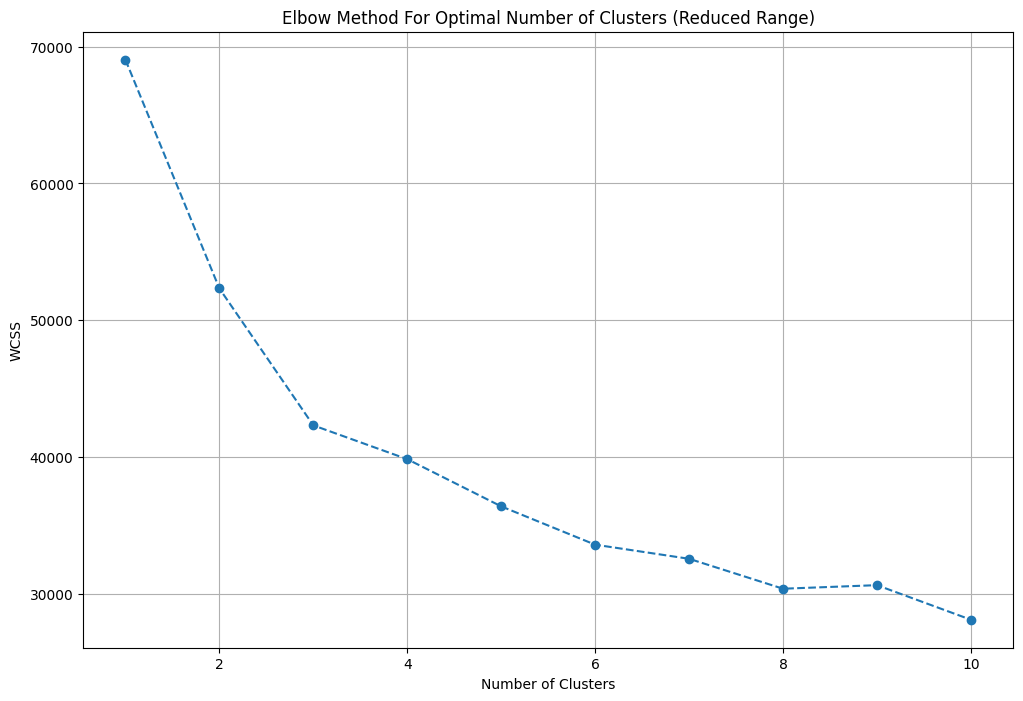

In [45]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [46]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [47]:
df = df.iloc[:,:-18]

In [48]:
df['furnishing_type'] = cluster_assignments

In [49]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
717,[],0
3953,NaN,0
3792,NaN,0
2253,"['5 Fan', '1 Exhaust Fan', '4 Geyser', '10 Light', '1 Chimney', '1 Modular Kitchen', '3 Wardrobe', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",1
2298,[],0


### 5.features

In [50]:
df[['society','features']].sample(5)

,society,features
2619,NaN,"['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Waste Disposal', 'Rain Water Harvesting']"
2030,smart world orchard,"['Security / Fire Alarm', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'No open drainage around', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center']"
3151,krisumi waterfall residences,"['Intercom Facility', 'Lift(s)', 'Park']"
2873,m3m woodshire,"['Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Swimming Pool', 'Park', 'Visitor Parking', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Rain Water Harvesting']"
1073,hector trimurti heights,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"


In [51]:
df['features'].isnull().sum()

671

In [52]:
appartments_df = pd.read_csv(r'D:\Projects\My_Estate_Project\data\raw\appartments.csv')
appartments_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"


In [54]:
appartments_df['PropertyName'] = appartments_df['PropertyName'].str.lower()

In [55]:
temp_df = df[df['features'].isnull()]

In [56]:
temp_df.shape

(671, 26)

In [57]:
x = temp_df.merge(appartments_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [58]:
df.loc[temp_df.index,'features'] = x.values

In [59]:
df['features'].isnull().sum()

526

In [61]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [62]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
1810,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
3315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1987,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0
67,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0


In [63]:
features_binary_df.shape

(3836, 130)

In [64]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

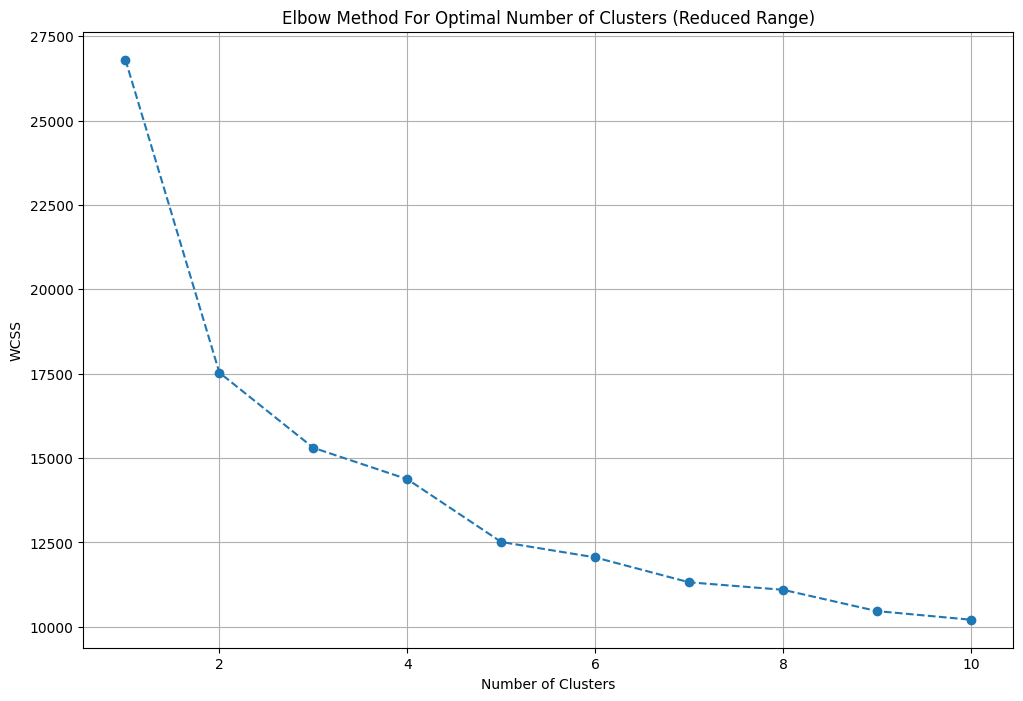

In [65]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [66]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [67]:
df['luxury_score'] = luxury_score

In [68]:
df.head(2)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,city heights,sector 39,1.75,8750.0,2000.0,Carpet area: 2000 (185.81 sq.m.),3,4,3,servant room,3.0,NaN,Old Property,"['Rajiv Chowk Mosque', 'Icici bank ATM', 'State bank of india ATM', 'Axis bank ATM', 'Hdfc bank ATM', 'State bank of india ATM', 'Medanta', ""DR AKRAM JAWED'S THE UPPER LIMB CLINIC"", 'Sukhmani Hospital Pvt. Ltd', 'Samvit Health Care', 'Dispencery', 'Bansal Medicare and Maternity Centre', 'Pushpanjali Hospital Gurgaon', 'Pushpanjali Hospital', 'Dayal Eye & Maternity Centre', 'Ahmed Hospital Multi Speciality', 'Airforce Hospital', 'Smile Plus Dental Clinic', 'Thakral Nursing and Maternity Home', 'Shivam Hospital Gurgaon', 'Aarvy Hospital', 'Park Hospital Gurgaon', 'Rajendra Hospital', 'Meher Clinic', 'Gurgaon Election Commission', 'Road and Traffic Authority', 'Gardian Pharmacy', 'IBP Petrol Pump', 'India Oil', 'Indian Oil', 'IBP Petrol Station', 'SRS Cinemas', 'Hdfc bank', 'KFC', 'Darbar', 'Om Sweets', 'Fast food', 'Fast Food', 'Raj Restaurant', 'Bar and restaurant', 'Haldiram', 'CR Model Public School', 'Kendriya Vidyalaya No.2 Sohna Road', 'Delhi Public School Primary Section', 'Manav Rachna School', 'Amity Global School', 'St. Angels Jr', 'Manav Rachna Swimming Pool']","['1 Water Purifier', '5 Fan', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '3 Geyser', '1 Stove', '9 Light', '1 AC', '1 Chimney', '5 Curtains', '1 Modular Kitchen', '1 TV', '3 Wardrobe', '1 Sofa', '1 Microwave', '1 Washing Machine', 'No Bed']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,NaN,2000.0,0,1,0,0,0,2,"[Feng Shui / Vaastu Compliant, Security / Fire Alarm, Lift(s), Maintenance Staff, Water Storage, Park, Visitor Parking]",42.0
1,flat,dlf the skycourt,sector 86,2.20,11500.0,1913.0,Super Built up area 1930(179.3 sq.m.),3,3,1,pooja room,7.0,NaN,Relatively New,"['Sapphire 83 Mall', 'NH-8, Imt Manesar', 'Rao Bharat Singh International School', 'DPG Institute of Technology', 'Aarvy Healthcare', 'Indira Gandhi International Airport', 'Imt Manesar', 'Holiday Inn Hotel Sector 90', 'Aapno Ghar', 'National Tennis Academy Sector 98']","['1 Water Purifier', '1 Fridge', '1 Exhaust Fan', '1 Dining Table', '2 Geyser', '1 Stove', '5 AC', '1 TV', '1 Modular Kitchen', '1 Chimney', '1 Curtains', '3 Bed', '3 Wardrobe', '1 Sofa', '1 Microwave', 'No Fan', 'No Light', 'No Washing Machine']","['Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'Water Storage', 'Bank Attached Property', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']",1930.0,NaN,NaN,0,0,0,1,0,2,"[Private Garden / Terrace, Intercom Facility, Lift(s), Water Storage, Bank Attached Property, Piped-gas, Visitor Parking, Swimming Pool, Park, Security Personnel, Internet/wi-fi connectivity, Shopping Centre, Fitness Centre / GYM, Club house / Community Center, Water softening plant]",77.0


In [69]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [70]:
df.sample(5)

,property_type,society,sector,price,Price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
2039,house,NaN,sector 4,3.25,14444.0,2250.0,Plot area 250(209.03 sq.m.),3,3,2,2.0,South-East,Old Property,NaN,2250.0,NaN,0,0,0,0,0,0,97.0
1197,flat,the close south,sector 50,3.10,12444.0,2491.0,Super Built up area 2491(231.42 sq.m.)Built Up area: 2450 sq.ft. (227.61 sq.m.)Carpet area: 2250 sq.ft. (209.03 sq.m.),3,4,3+,4.0,North-East,Moderately Old,2491.0,2450.0,2250.0,0,1,0,0,0,1,29.0
828,flat,emaar mgf emerald floors premier,sector 65,2.40,14545.0,1650.0,Super Built up area 1650(153.29 sq.m.)Built Up area: 1600 sq.ft. (148.64 sq.m.)Carpet area: 1250 sq.ft. (116.13 sq.m.),3,3,3,3.0,East,Relatively New,1650.0,1600.0,1250.0,1,1,0,0,0,1,44.0
3449,house,NaN,sector 4,1.10,11111.0,990.0,Built Up area: 990 (91.97 sq.m.),6,4,1,2.0,North,Undefined,NaN,990.0,NaN,0,0,0,0,0,0,0.0
3092,flat,m3m skycity,sector 65,2.00,15267.0,1310.0,Super Built up area 1310(121.7 sq.m.),2,2,2,16.0,East,New Property,1310.0,NaN,NaN,0,0,0,0,0,1,145.0


In [71]:
df.shape

(3836, 23)

In [79]:
df.to_csv('D:/Projects/My_Estate_Project/data/raw/gurgaon_properties_cleaned_v2.csv',index=False)